<a href="https://colab.research.google.com/github/gabriel-martins-souza/projects/blob/main/Forecasting_Storage_Onboarding_in_Filecoin_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



<hr>
<a class="anchor" id="import">
    
# 1.0 Import
    
</a>


In [1]:
#common packages
import pandas as pd
import numpy as np
import scipy as sp
from math import ceil, pi
import os
from itertools import product
import warnings
warnings.filterwarnings("ignore")

#dataviz
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
#restarting matplotlib
%matplotlib inline
plt.close('all')

#importing stock data from Yahoo Finance
!pip install yfinance
import yfinance as yf

#algorithms for data preparation and preprocessing
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import RFE

#libs for model assessment
from sklearn.metrics import mean_squared_error as MSE, r2_score, mean_absolute_percentage_error as MAPE

#import libs for ML modeling
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.neural_network import MLPRegressor

#Time Series and Modeling
!pip install pmdarima
from pmdarima import auto_arima
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.8/112.8 KB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 22.2 MB/s eta 0:00:00
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting un

In [2]:
# reads the csv files to a pandas dataframe named 'df'
df = pd.read_csv('/content/drive/MyDrive/Master Data Science NOVA IMS/Notebooks/data/storage_power2021-01-01_2023-02-20.csv', sep=',')

In [3]:
df.head()

,request_id,code,message,stat_date,miner_id,raw_byte_power,quality_adj_power
0,807410cd-217e-43dc-9cef-8b2b76f5e743#1010033,0,success.,2021-01-01T00:00:00Z,f0100066,0,0
1,807410cd-217e-43dc-9cef-8b2b76f5e743#1010033,0,success.,2021-01-01T00:00:00Z,f010048,66005057404928,66005057404928
2,807410cd-217e-43dc-9cef-8b2b76f5e743#1010033,0,success.,2021-01-01T00:00:00Z,f010038,82841329205248,82841329205248
3,807410cd-217e-43dc-9cef-8b2b76f5e743#1010033,0,success.,2021-01-01T00:00:00Z,f0100082,476810089332736,476810089332736
4,807410cd-217e-43dc-9cef-8b2b76f5e743#1010033,0,success.,2021-01-01T00:00:00Z,f010088,72086731096064,72086731096064


In [4]:
#checks the min() and max() stat_date
print(df['stat_date'].min() , df['stat_date'].max())

2021-01-01T00:00:00Z 2023-02-20T00:00:00Z


In [4]:
# Defines the date parameters to retrieve historical data 
start_date = "2021-01-01"
end_date = "2023-02-21"

#imports historical data from Filecoint using yahoo Finance API
fil_data = yf.download('FIL-USD', start= start_date, end= end_date, interval='1d')

#resets the datafram index
fil_data = fil_data.reset_index()

#converts all the features to lower case
fil_data = fil_data.rename(columns=lambda x: x.lower())

#checks the df header
fil_data.head()

[*********************100%***********************]  1 of 1 completed


,date,open,high,low,close,adj close,volume
0,2021-01-01,24.359148,24.958113,22.023264,22.291010,22.291010,348030664
1,2021-01-02,22.288815,23.133966,21.432627,21.808891,21.808891,243646888
2,2021-01-03,21.817991,21.873875,21.029001,21.426378,21.426378,272432560
3,2021-01-04,21.434067,22.923031,21.011490,21.467407,21.467407,312309245
4,2021-01-05,21.428017,22.291952,21.060802,21.632771,21.632771,213135095


In [6]:
#checks the min() and max() Date in Fil dataset
print(fil_data['date'].min() , fil_data['date'].max())

2021-01-01 00:00:00 2023-02-20 00:00:00


<hr>
<a class="anchor" id="data_understanding">
    
## 2.0 Data Understanding
    
</a>

**EDA of fil_data dataset obtained from Yfinance API**

In [ ]:
#checks if there are null values in the dataset
fil_data.isna().sum()

date         0
open         0
high         0
low          0
close        0
adj close    0
volume       0
dtype: int64

In [ ]:
#checks general info of the dataset
fil_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 781 entries, 0 to 780
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       781 non-null    datetime64[ns]
 1   open       781 non-null    float64       
 2   high       781 non-null    float64       
 3   low        781 non-null    float64       
 4   close      781 non-null    float64       
 5   adj close  781 non-null    float64       
 6   volume     781 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 42.8 KB


In [ ]:
#describes the main statistics
fil_data.describe()

,open,high,low,close,adj close,volume
count,781.000000,781.000000,781.000000,781.000000,781.000000,7.810000e+02
mean,38.202910,40.060254,36.288813,38.175546,38.175546,6.986412e+08
std,40.325964,42.718962,38.108268,40.346698,40.346698,9.618457e+08
min,2.808193,2.965434,2.678534,2.806761,2.806761,4.127013e+07
25%,5.829846,6.039844,5.617069,5.830133,5.830133,2.052785e+08
50%,22.016642,22.752178,21.381483,21.969751,21.969751,3.906103e+08
75%,59.053757,62.673992,56.035103,59.123135,59.123135,8.123473e+08
max,191.153915,237.241821,182.714111,191.356552,191.356552,1.236798e+10


In [ ]:
#checks duplicates in the dataset
fil_data.duplicated().sum()

0

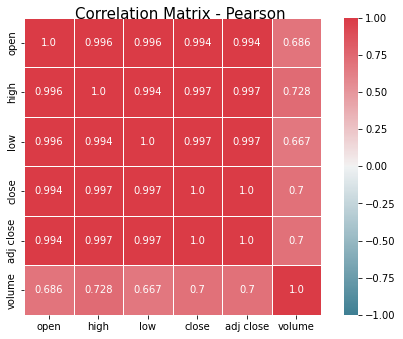

In [ ]:
#Correlation Matrix - Pearson

# Prepare figure
fig = plt.figure(figsize=(8, 5))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(fil_data.corr(method="pearson"), decimals=3)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) 

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix - Pearson", fontsize=15)
plt.show()

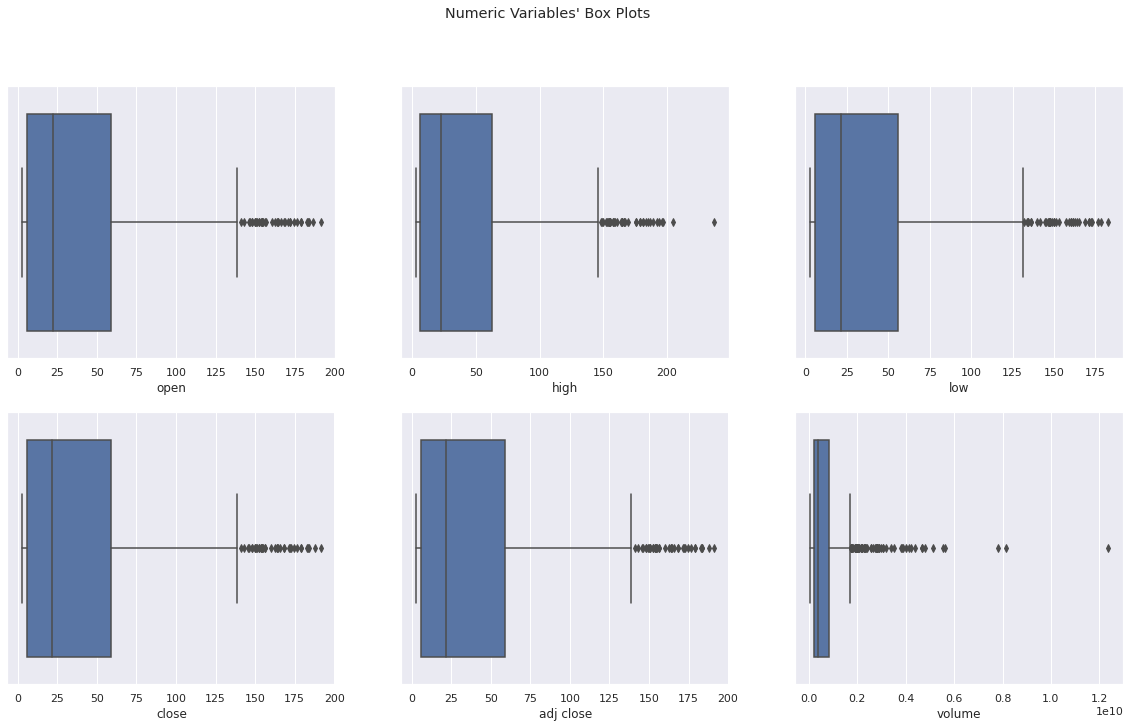

In [ ]:
# All Numeric Variables' Box Plots in one figure
sns.set()

metric_feat = fil_data.columns.drop('date').to_list()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(metric_feat) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_feat): # Notice the zip() function and flatten() method
    sns.boxplot(x=fil_data[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"

plt.suptitle(title)

plt.show()

**EDA of Storage Onboarding data obtained from API Spacescope**

In [ ]:
#describes the main statistics from the dataset
df.describe()

,code,raw_byte_power,quality_adj_power
count,3366761.0,3.366761e+06,3.366761e+06
mean,0.0,3.209079e+15,3.453804e+15
std,0.0,9.016948e+15,9.189112e+15
min,0.0,0.000000e+00,0.000000e+00
25%,0.0,2.164664e+12,2.404095e+12
50%,0.0,5.707840e+14,6.816972e+14
75%,0.0,2.595122e+15,2.943828e+15
max,0.0,1.790324e+17,1.790324e+17


In [ ]:
#shows the general information from the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3366761 entries, 0 to 3366760
Data columns (total 7 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   request_id         object
 1   code               int64 
 2   message            object
 3   stat_date          object
 4   miner_id           object
 5   raw_byte_power     int64 
 6   quality_adj_power  int64 
dtypes: int64(3), object(4)
memory usage: 179.8+ MB


In [ ]:
#sums up the number os null observations
df.isna().sum()

request_id           0
code                 0
message              0
stat_date            0
miner_id             0
raw_byte_power       0
quality_adj_power    0
dtype: int64

In [ ]:
#brings the duplicated observations, if exists
df.duplicated().sum()

0

In [ ]:
#checks the unique codes
df['code'].unique()

array([0])

In [ ]:
#checks the unique messages
df['message'].unique()

array(['success.'], dtype=object)

In [ ]:
#checks the amount of records for each miner_id
df.groupby('miner_id')['request_id'].count().sort_values(ascending=False)

miner_id
f0100033     781
f024148      781
f02401       781
f024012      781
f024013      781
            ... 
f02032191      3
f02038992      3
f01927170      3
f02038720      2
f02041586      1
Name: request_id, Length: 6001, dtype: int64

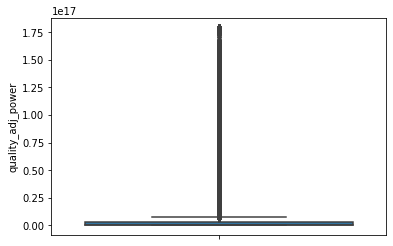

In [ ]:
# Single Metric Variable Box Plot
sns.boxplot(y=df["raw_byte_power"])

plt.show()

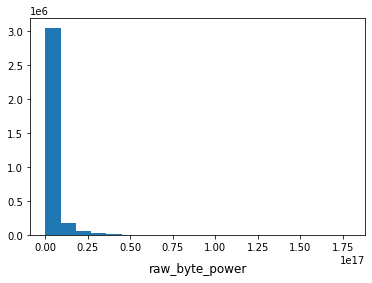

In [ ]:
# Single Metric Variable Histogram
plt.hist(df["raw_byte_power"], bins=20)  # mess around with the bins
plt.title("raw_byte_power", y=-0.2)

plt.show()

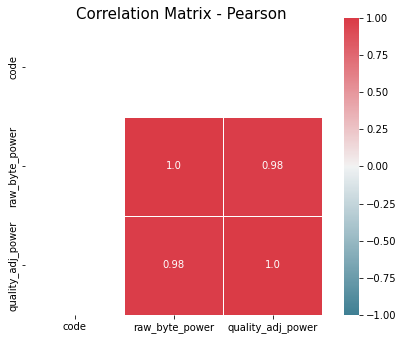

In [ ]:
#Correlation Matrix - Pearson

# Prepare figure
fig = plt.figure(figsize=(8, 5))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(df.corr(method="pearson"), decimals=3)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) 

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix - Pearson", fontsize=15)
plt.show()

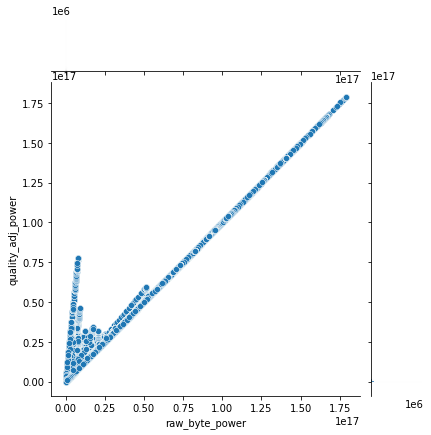

In [ ]:
# making a joint plot between raw and quality_adj power
sns.set(style="ticks")
sns.jointplot(data=df, x="raw_byte_power", y="quality_adj_power", kind="hex", color="red")
plt.show()

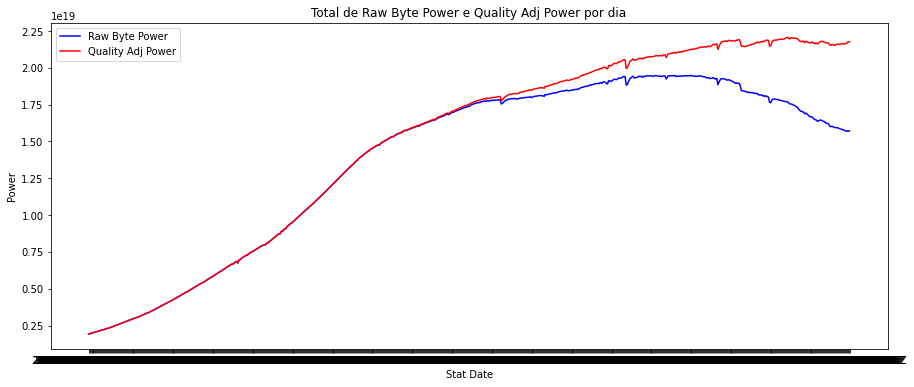

In [ ]:
#plt.figure(figsize=(15, 6))

# Calcula a soma dos valores de raw_byte_power e quality_adj_power para cada dia
df_sum = df.groupby('stat_date')[['raw_byte_power', 'quality_adj_power']].sum().reset_index()

# Cria um gráfico de linha com a variável 'raw_byte_power' ao longo do tempo 'stat_date'
sns.lineplot(x='stat_date', y='raw_byte_power', data=df_sum, color='blue', label='Raw Byte Power')

# Adiciona uma nova linha ao gráfico com a variável 'quality_adj_power'
sns.lineplot(x='stat_date', y='quality_adj_power', data=df_sum, color='red', label='Quality Adj Power')

# Adiciona um título ao gráfico
plt.title('Total de Raw Byte Power e Quality Adj Power por dia')

# Adiciona rótulos aos eixos x e y
plt.xlabel('Stat Date')
plt.ylabel('Power')

# Mostra o gráfico
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

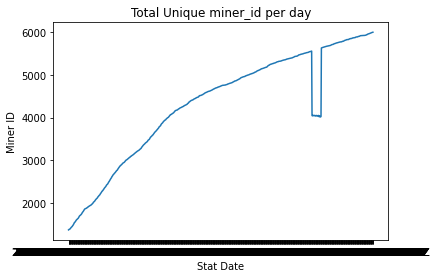

In [ ]:
#creates a dataframe with the daily amount of distinct miner_id
df_miner_count = df.groupby('stat_date')['miner_id'].nunique().reset_index()

# creates a visualization with miner_id in Y and stat_date in X axis
sns.lineplot(x='stat_date', y='miner_id', data=df_miner_count)

# Names the graph
plt.title('Total Unique miner_id per day')

# Inputs the axis labels
plt.xlabel('Stat Date')
plt.ylabel('Miner ID')

# Shows the visualization
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

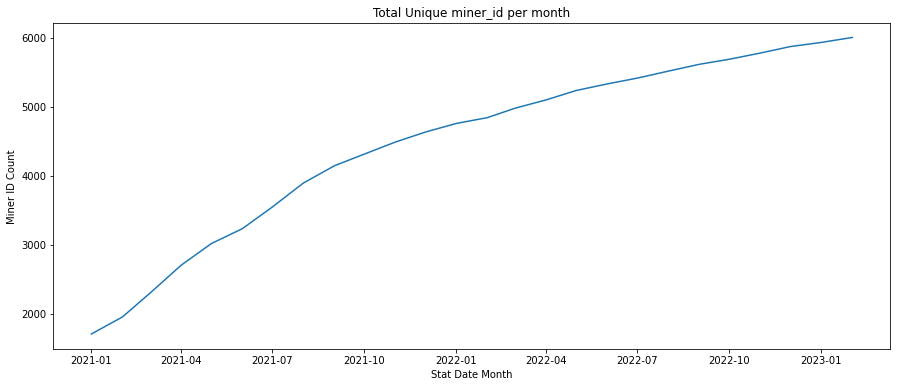

In [ ]:
#creates a copy from df
df_copy = df.copy()

# Converte a variável 'stat_date' para o tipo 'date'
df_copy['stat_date'] = pd.to_datetime(df_copy['stat_date'])

# Transforma a variável 'stat_date' no formato 'yyyy-mm'
df_copy['stat_date'] = df_copy['stat_date'].dt.to_period('M')

# Agrupa os dados por 'stat_date' mensal e faz a contagem de 'miner_id'
df_monthly_miner_id = df_copy.groupby('stat_date')['miner_id'].nunique().reset_index()

df_monthly_miner_id['stat_date'] = df_monthly_miner_id['stat_date'].dt.to_timestamp()

#Figure Size
plt.figure(figsize=(15, 6))

# creates a visualization with miner_id in Y and stat_date in X axis
sns.lineplot(x='stat_date', y='miner_id', data=df_monthly_miner_id)

# Names the graph
plt.title('Total Unique miner_id per month')

# Inputs the axis labels
plt.xlabel('Stat Date Month')
plt.ylabel('Miner ID Count')

# Shows the visualization
plt.show


<hr>
<a class="anchor" id="data_preparation">
    
# 3.0 Data Preparation
    
</a>

In [5]:
#creates a copy from df
df_prep = df.copy()

#deletes the columns with no relevant information 
df_prep = df_prep.drop(columns=['request_id', 'code', 'message'])

# converts the units from bytes to terabytes
#df_prep['tb_raw_power'] = df_prep['raw_byte_power'] / 1000000000000 #convert bytes to terabytes
#df_prep['tb_quality_power'] = df_prep['quality_adj_power'] / 1000000000000


# creates a dataframe aggregating the numeric metrics 
df_agg = df_prep.groupby('stat_date').agg({'miner_id': 'nunique', 
                                           'raw_byte_power': 'sum', 
                                           'quality_adj_power': 'sum'}).reset_index()

#renames column miner_id
df_storage = df_agg.rename(columns={'miner_id': 'unique_miners', 'stat_date':'date'})
                                        
#show df header
df_storage.head()

,date,unique_miners,raw_byte_power,quality_adj_power
0,2021-01-01T00:00:00Z,1363,1.930035e+18,1.930161e+18
1,2021-01-02T00:00:00Z,1371,1.951233e+18,1.951369e+18
2,2021-01-03T00:00:00Z,1379,1.971092e+18,1.971237e+18
3,2021-01-04T00:00:00Z,1381,1.987660e+18,1.987821e+18
4,2021-01-05T00:00:00Z,1388,2.007411e+18,2.007596e+18


In [6]:
#converts the date to type datetime
df_storage['date'] = pd.to_datetime(df_storage['date'], format='%Y-%m-%d')

#removes the “00:00:00+00:00” in the date field
df_storage['date'] = df_storage['date'].dt.date

#show df header
df_storage.head()

,date,unique_miners,raw_byte_power,quality_adj_power
0,2021-01-01,1363,1.930035e+18,1.930161e+18
1,2021-01-02,1371,1.951233e+18,1.951369e+18
2,2021-01-03,1379,1.971092e+18,1.971237e+18
3,2021-01-04,1381,1.987660e+18,1.987821e+18
4,2021-01-05,1388,2.007411e+18,2.007596e+18


In [7]:
#creates a copy from fil_data
fil_prep = fil_data.copy()

#deletes the columns with no relevant information 
fil_prep = fil_prep.drop(columns=['high', 'low', 'close','adj close'])

#renames columns
fil_prep = fil_prep.rename(columns={'open': 'open_price', 'volume':'traded_volume'})

#converts the date to type datetime
fil_prep['date'] = fil_prep['date'].dt.date

#shows the fil_prep dataset header
fil_prep.head()

,date,open_price,traded_volume
0,2021-01-01,24.359148,348030664
1,2021-01-02,22.288815,243646888
2,2021-01-03,21.817991,272432560
3,2021-01-04,21.434067,312309245
4,2021-01-05,21.428017,213135095


**Merging information of daily Storage and Prices of Filecoin**

In [8]:
#merges the two dataset fil_prep and df_storage into one named df_merged
df_merged = pd.merge(fil_prep, df_storage, on='date', how='inner')

#print new dataframe
df_merged

,date,open_price,traded_volume,unique_miners,raw_byte_power,quality_adj_power
0,2021-01-01,24.359148,348030664,1363,1.930035e+18,1.930161e+18
1,2021-01-02,22.288815,243646888,1371,1.951233e+18,1.951369e+18
2,2021-01-03,21.817991,272432560,1379,1.971092e+18,1.971237e+18
3,2021-01-04,21.434067,312309245,1381,1.987660e+18,1.987821e+18
4,2021-01-05,21.428017,213135095,1388,2.007411e+18,2.007596e+18
...,...,...,...,...,...,...
776,2023-02-16,5.479461,401387749,5989,1.571146e+19,2.164387e+19
777,2023-02-17,5.398729,1539223863,5992,1.568408e+19,2.164992e+19
778,2023-02-18,7.668670,842413279,5999,1.572855e+19,2.174316e+19
779,2023-02-19,7.514821,1727690437,6000,1.571486e+19,2.176028e+19


In [54]:
#display.float_format', lambda x: f'{x:.3f}')

In [57]:
#pd.reset_option('display.float_format')

In [9]:
#creates fil_plus_rate
df_merged['fil_plus_rate'] = (df_merged['quality_adj_power'] / df_merged['raw_byte_power'] - 1) / 9
df_merged.head()

,date,open_price,traded_volume,unique_miners,raw_byte_power,quality_adj_power,fil_plus_rate
0,2021-01-01,24.359148,348030664,1363,1.930035e+18,1.930161e+18,0.000007
1,2021-01-02,22.288815,243646888,1371,1.951233e+18,1.951369e+18,0.000008
2,2021-01-03,21.817991,272432560,1379,1.971092e+18,1.971237e+18,0.000008
3,2021-01-04,21.434067,312309245,1381,1.987660e+18,1.987821e+18,0.000009
4,2021-01-05,21.428017,213135095,1388,2.007411e+18,2.007596e+18,0.000010


In [10]:
#calculates the daily variation of Storage variables

#creates delta raw_byte_power
df_merged['delta_RBP'] = df_merged['raw_byte_power'].diff().fillna(0)

#creates delta quality_adj_power
df_merged['delta_QAP'] = df_merged['quality_adj_power'].diff().fillna(0)

#creates delta fil_plus_rate 
df_merged['delta_fil_plus_rate'] = df_merged['fil_plus_rate'].diff().fillna(0)

#creates delta unique_miners
df_merged['delta_miners'] = df_merged['unique_miners'].diff().fillna(0)

df_merged.head()

,date,open_price,traded_volume,unique_miners,raw_byte_power,quality_adj_power,fil_plus_rate,delta_RBP,delta_QAP,delta_fil_plus_rate,delta_miners
0,2021-01-01,24.359148,348030664,1363,1.930035e+18,1.930161e+18,0.000007,0.000000e+00,0.000000e+00,0.000000e+00,0.0
1,2021-01-02,22.288815,243646888,1371,1.951233e+18,1.951369e+18,0.000008,2.119872e+16,2.120816e+16,4.583422e-07,8.0
2,2021-01-03,21.817991,272432560,1379,1.971092e+18,1.971237e+18,0.000008,1.985869e+16,1.986777e+16,4.341237e-07,8.0
3,2021-01-04,21.434067,312309245,1381,1.987660e+18,1.987821e+18,0.000009,1.656785e+16,1.658385e+16,8.262008e-07,2.0
4,2021-01-05,21.428017,213135095,1388,2.007411e+18,2.007596e+18,0.000010,1.975146e+16,1.977480e+16,1.203735e-06,7.0


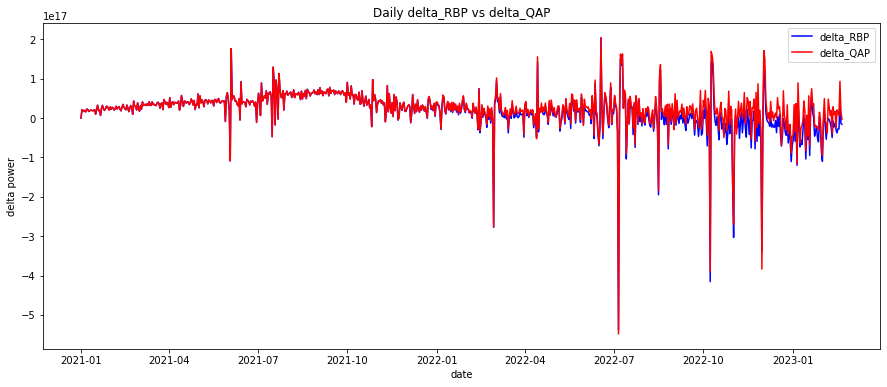

In [11]:
plt.figure(figsize=(15, 6))

# creates a line plot with delta_RBP as blue
sns.lineplot(x='date', y='delta_RBP', data=df_merged, color='blue', label='delta_RBP')

# creates a line plot with delta_QAP as red
sns.lineplot(x='date', y='delta_QAP', data=df_merged, color='red', label='delta_QAP')

# adds title
plt.title('Daily delta_RBP vs delta_QAP')

# adds the axis labels
plt.xlabel('date')
plt.ylabel('delta power')

# plots the visualization
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

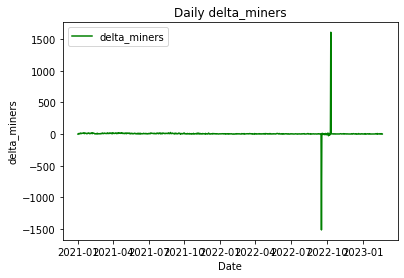

In [12]:
# creates a daily delta_miners visualization
sns.lineplot(x='date', y='delta_miners', data=df_merged, color='green', label='delta_miners')

# Names the graph
plt.title('Daily delta_miners')

# Inputs the axis labels
plt.xlabel('Date')
plt.ylabel('delta_miners')

# Shows the visualization
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

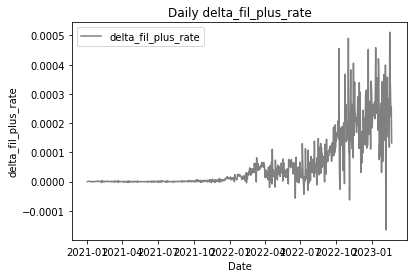

In [13]:
# creates a daily file_plus_rate visualization
sns.lineplot(x='date', y='delta_fil_plus_rate', data=df_merged, color='gray', label='delta_fil_plus_rate')

# Names the graph
plt.title('Daily delta_fil_plus_rate')

# Inputs the axis labels
plt.xlabel('Date')
plt.ylabel('delta_fil_plus_rate')

# Shows the visualization
plt.show

In [20]:
#checks for null values
df_merged.isna().sum()

date                 0
open_price           0
traded_volume        0
unique_miners        0
raw_byte_power       0
quality_adj_power    0
delta_RBP            0
delta_QAP            0
delta_miners         0
dtype: int64

In [16]:
#checks duplicated rows
df_merged.duplicated().sum()

0

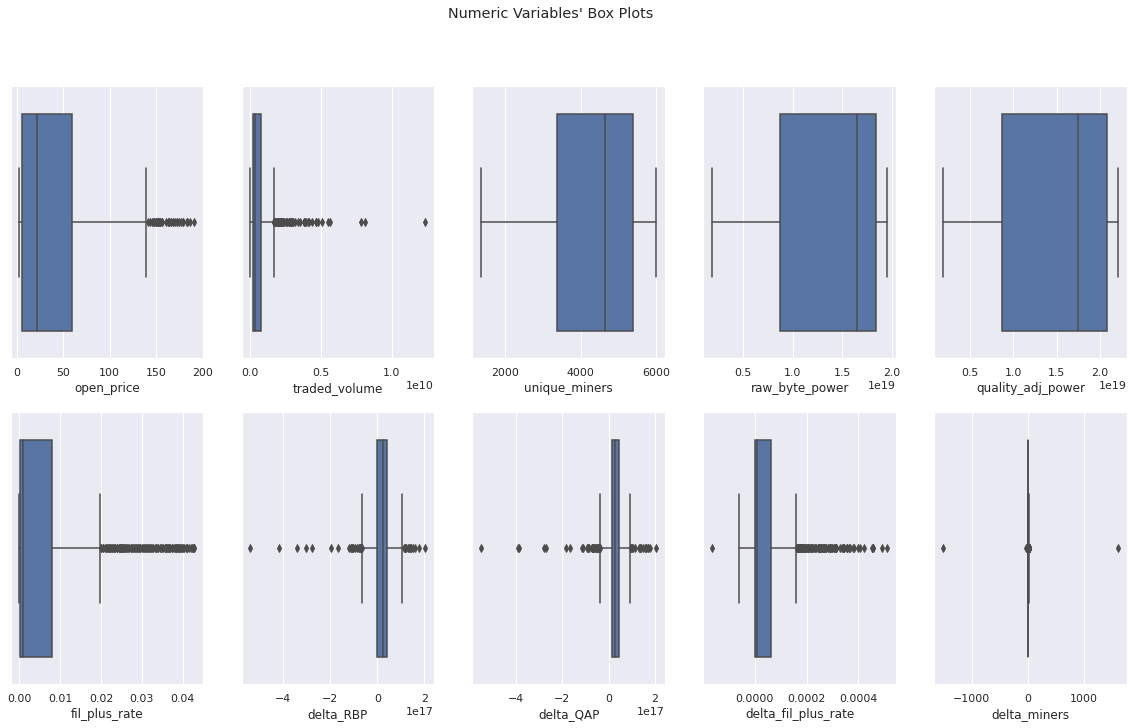

In [17]:
# All Numeric Variables' Box Plots in one figure
sns.set()

metric_feat = df_merged.columns.drop('date').to_list()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(metric_feat) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_feat): # Notice the zip() function and flatten() method
    sns.boxplot(x=df_merged[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"

plt.suptitle(title)

plt.show()

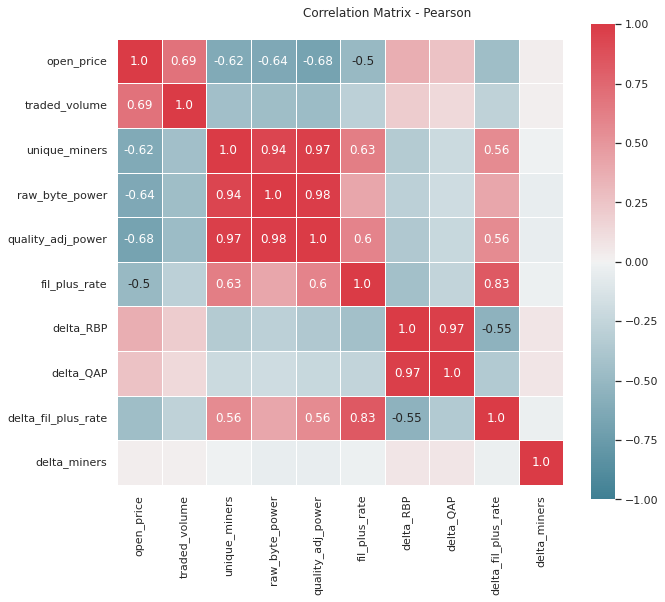

In [20]:
#Correlation Matrix - Pearson

# Prepare figure
fig = plt.figure(figsize=(10, 8))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(df_merged.corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) 

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix - Pearson", fontsize=12)
plt.show()

In [14]:
#creating a copy of the dataset to test IQR outlier removal method
df_iqr = df_merged.copy()

In [16]:
# Applying the technique IQR for outlier removal

metric_feat = df_merged.columns.drop('date').to_list()

q25 = df_merged.quantile(.25)
q75 = df_merged.quantile(.75)
iqr = (q75 - q25)

upper_lim = q75 + 3 * iqr
lower_lim = q25 - 3 * iqr

filters = []
for metric in metric_feat:
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    filters.append(df_iqr[metric].between(llim, ulim, inclusive=True))

df_iqr_2 = df_iqr[np.all(filters, 0)]
print('Percentage of data kept after removing outliers:', np.round(df_iqr_2.shape[0] / df_iqr.shape[0], 4))

Percentage of data kept after removing outliers: 0.8438


<hr>
<a class="anchor" id="modeling">
    
# 4.0 Modeling
    
</a>

**Stationary Process Analysis**

In [23]:
#creating a copy from df_merged to perform stationarity test
df_baseline = df_merged.copy()

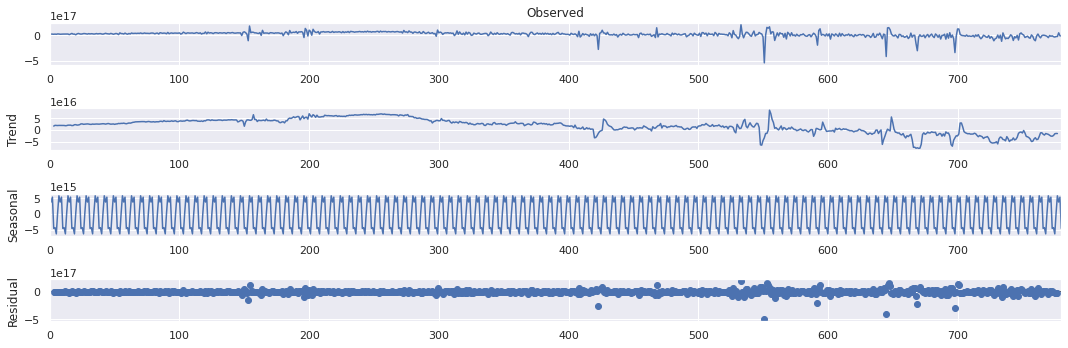

In [25]:
#Using date as dataframe index
df_baseline.index = df_baseline['date']

#Time Series Decompose for the raw_byte_power 
decompose = seasonal_decompose(df_baseline.delta_RBP.values, period = 7, model="additive")
plt.rcParams.update({'figure.figsize':(15,5)})
f = decompose.plot()

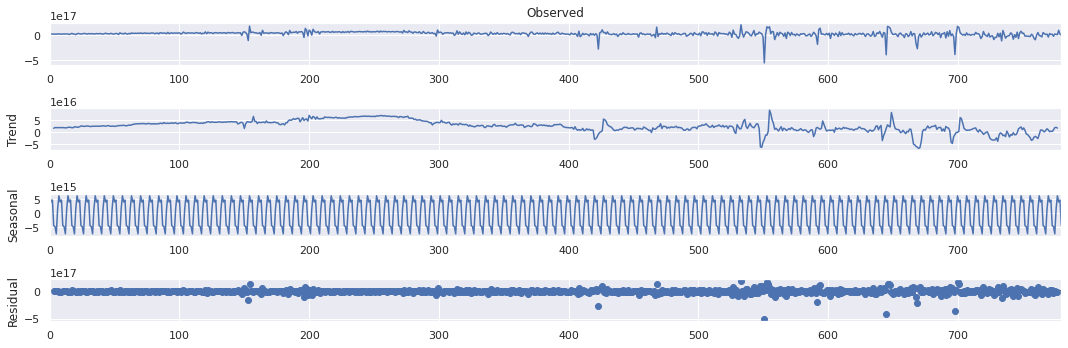

In [26]:
#Time Series Decompose for the quality_adj_power 
decompose = seasonal_decompose(df_baseline.delta_QAP.values, period = 7, model="additive")
plt.rcParams.update({'figure.figsize':(15,5)})
f = decompose.plot()

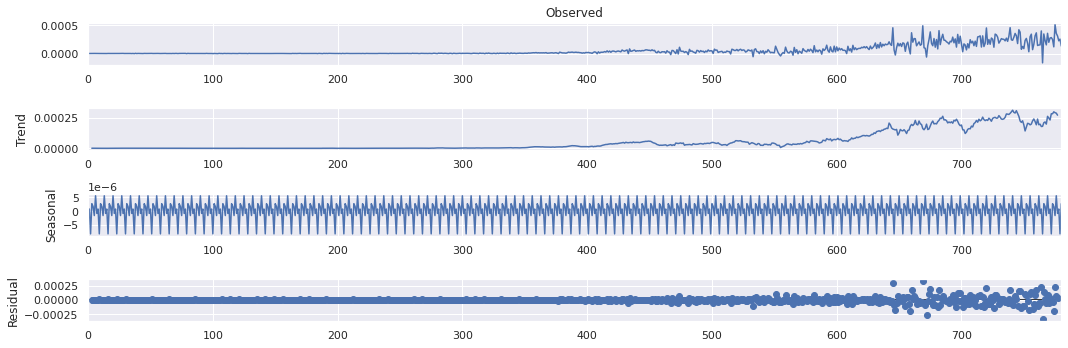

In [27]:
#Time Series Decompose for the delta_fil_plus_rate 
decompose = seasonal_decompose(df_baseline.delta_fil_plus_rate.values, period = 7, model="additive")
plt.rcParams.update({'figure.figsize':(15,5)})
f = decompose.plot()

#### Stationary Process Test
- Hypothesis test: 
- Ho: The data has a unit root and is non-stationary; H1: The data does not have a unit root and is stationary.
- Note: if p-value > 0.05: Fail to reject the null hypothesis (H0), otherwise Reject the null hypothesis (H0).

In [28]:
#creates function to verify stationarity with Dickey-Fuller test

def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,maxlag=7*4, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (round(dfoutput,3))

In [29]:
# defines a function to apply differentiation in Times Series in case of non-stationarity
def invert_diff(series, first_element_before):
    cumsum = series.cumsum()
    return cumsum.fillna(0) + first_element_original

In [30]:
#testing stationarity in raw_byte_power
test_stationarity(df_baseline.delta_RBP)
"""Since the p-value is greater than 0.05, we fail to reject the null hypothesis. This means the time series is non-stationary."""

Results of Dickey-Fuller Test:
Test Statistic                  -1.306
p-value                          0.626
#Lags Used                      19.000
Number of Observations Used    761.000
Critical Value (1%)             -3.439
Critical Value (5%)             -2.865
Critical Value (10%)            -2.569
dtype: float64


'Since the p-value is greater than 0.05, we fail to reject the null hypothesis. This means the time series is non-stationary.'

<AxesSubplot:xlabel='date'>

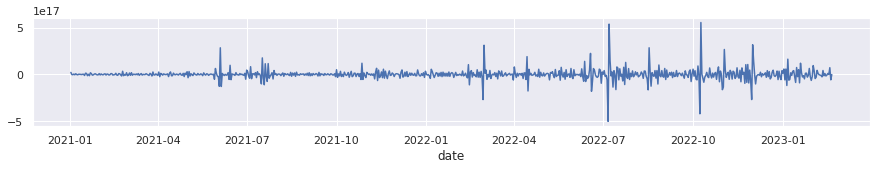

In [32]:
#applying diff function in raw_byte_power series
diff_raw_byte = diff(df_baseline.delta_RBP,seasonal_periods=1)
diff_raw_byte.plot(figsize=(15,2))

In [33]:
#testing if the diff_raw_byte df is stationary
test_stationarity(diff_raw_byte)

Results of Dickey-Fuller Test:
Test Statistic                  -9.321
p-value                          0.000
#Lags Used                      28.000
Number of Observations Used    751.000
Critical Value (1%)             -3.439
Critical Value (5%)             -2.865
Critical Value (10%)            -2.569
dtype: float64


With the prior stationarity tests it is possible to notice that the Time Series requires some specific parameters to deal with the non-stationarity process. In the following steps the ARIMA model and some features as the autoarima are going to be used do find the best hyper parameters.

<hr>
<a class="anchor" id="arima">
    
# 4.1 ARIMA
    
</a>

**Modeling Goal:**
- Predicts delta_RBP
- Predicts the daily delta Fil_Plus_rate
  - fil_plus_rate = (delta_QAP/deltaRBP-1)/9 

In [34]:
#creates a copy from df_merged
df_arima = df_merged.copy()

In [35]:
df_arima.columns

Index(['date', 'open_price', 'traded_volume', 'unique_miners',
       'raw_byte_power', 'quality_adj_power', 'fil_plus_rate', 'delta_RBP',
       'delta_QAP', 'delta_fil_plus_rate', 'delta_miners'],
      dtype='object')

**Noise and distribution Analysis**

In [88]:
# defines the input and output variables
y = df_arima['delta_fil_plus_rate']
X = df_arima[['delta_miners', 'delta_QAP', 'fil_plus_rate','delta_fil_plus_rate']]

In [89]:
# Splits the dataset in Train and Test
train_size = int(len(df_arima) * 0.8)
train_y = y[:train_size]
train_X = X[:train_size]
test_y = y[train_size:]
test_X = X[train_size:]

In [91]:
# Finding the best parameters with Auto-Arima
fit_arima = auto_arima(train_y, exogenous=train_X, d=1, start_p=1, start_q=1, max_p=2, max_q=2,
                    seasonal=True, 
                           m=6, 
                           D=1, 
                           start_P=1, 
                           start_Q=1, 
                           max_P=2, 
                           max_Q=2, 
                           information_criterion='aic',
                           suppress_warnings=True,
                           trace=False, 
                           error_action='ignore', 
                           stepwise=False) 

In [92]:
#prints de autoarima results
print(fit_arima.summary())

#article for reference on how to analyze the results https://analyzingalpha.com/interpret-arima-results

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                  624
Model:             SARIMAX(0, 1, 1)x(2, 1, [1, 2], 6)   Log Likelihood                5770.028
Date:                                Sun, 12 Mar 2023   AIC                         -11528.056
Time:                                        15:01:50   BIC                         -11501.507
Sample:                                    01-01-2021   HQIC                        -11517.734
                                         - 09-16-2022                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9073   1.25e-19  -7.28e+18      0.000      -0.907      -0.907
ar.

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


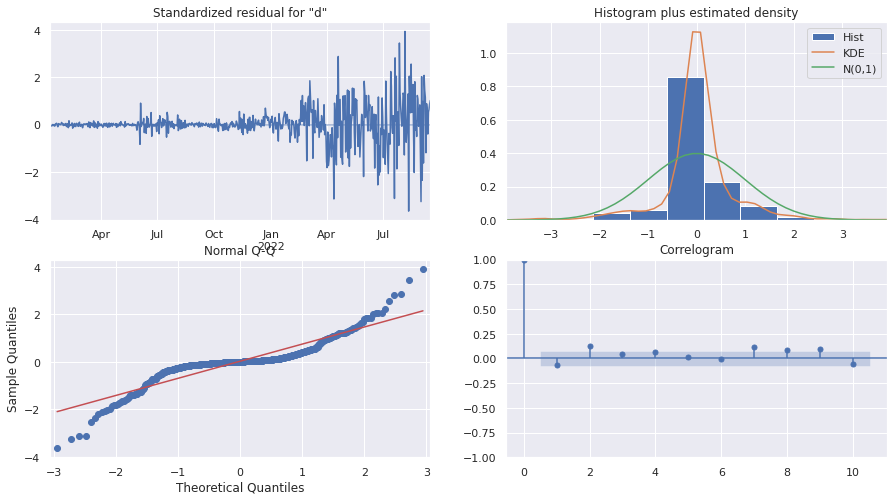

Ljung-box p-values:
[9.43223716e-02 1.78690844e-03 2.72437808e-03 1.89096949e-03
 4.12122301e-03 8.41609296e-03 4.33691662e-04 1.52080887e-04
 2.82447661e-05 2.83283722e-05 1.49609061e-05 1.86181482e-05]


In [93]:
# Init the best SARIMAX model
model = SARIMAX(
    train_y,
    exog=train_X,
    order=fit_arima.order,
    seasonal_order = fit_arima.seasonal_order
)

# training the model
results = model.fit()


#performs the function for the distribution diagnostic
results.plot_diagnostics(figsize=(15, 8))

plt.show()
print("Ljung-box p-values:\n" + str(results.test_serial_correlation(method='ljungbox')[0][1]))

**Using a Foor Loop to evaluate ARIMA in 'delta_RBP' and 'delta_fil_plus_rate' features - Last 180 days**

In [24]:
#creates a copy from df_merged
df_arima = df_merged.copy()

# Set the 'date' variable as the dataframe index
df_arima.set_index('date', inplace=True)

#select only the last 180 days from de dataframe
df_arima = df_arima[-180:]

In [25]:
# Defines y and x variables
y_var = df_arima[['delta_RBP', 'delta_fil_plus_rate']].columns.to_list()
print(y_var)

['delta_RBP', 'delta_fil_plus_rate']


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAPE: 504.5243897591
RMSE: 62767595074232680.0000000000
mape_2: 5.0452438976
rmse_2: 62767595074232680.0000000000


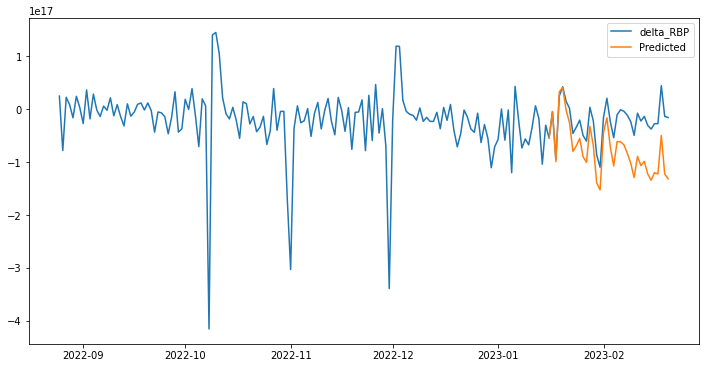

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAPE: 53.3632526296
RMSE: 0.0001008533
mape_2: 0.5336325263
rmse_2: 0.0001008533


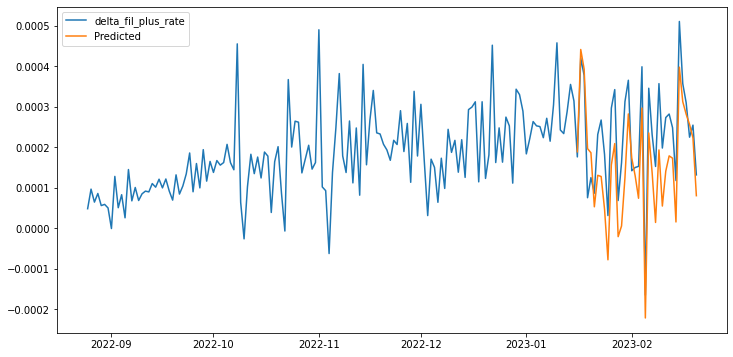

In [26]:
# Loop through the output variables
for y in y_var:
  # Define input and output variables
  X = df_arima.drop(y, axis=1)
  y = df_arima[y] 

  # Scale the variables
  scaler = StandardScaler()
  X = scaler.fit_transform(X)

  # Splits the dataset in Train and Test
  train_size = int(len(df_arima) * 0.8)
  train_y = y[:train_size]
  train_X = X[:train_size]
  test_y = y[train_size:]
  test_X = X[train_size:]

  # Finding the best parameters with Auto-Arima 
  # More details of auto_arima at https://alkaline-ml.com/pmdarima/tips_and_tricks.html
  fit_arima = auto_arima(train_y, exogenous=train_X, d=1, start_p=1, start_q=1, max_p=2, max_q=2,
                      seasonal=True, 
                            m=6, 
                            D=1, 
                            start_P=1, 
                            start_Q=1, 
                            max_P=2, 
                            max_Q=2, 
                            information_criterion='aic',
                            suppress_warnings=True,
                            trace=False, 
                            error_action='ignore', 
                            stepwise=False) 
  
  #creates the model ARIMA with the input variables as 'exog' and the parameters from auto_arima
  model = sm.tsa.statespace.SARIMAX(train_y, exog=train_X, order=fit_arima.order, seasonal_order=fit_arima.seasonal_order)
  arima_model = model.fit()

  #uses the arima_model to predict using the train set
  pred_y = arima_model.predict(start=train_size, end=len(df_arima) - 1, exog=test_X)

  #evaluates the prediction error using MAPE and RMSE
  mape = np.mean(np.abs((test_y - pred_y) / test_y)) * 100
  rmse = np.sqrt(np.mean((test_y - pred_y) ** 2))
  
  print("MAPE:","{:.10f}".format(mape))
  print("RMSE:","{:.10f}".format(rmse))
  
  #plots the series Real vs Predicted
  plt.figure(figsize=(12, 6))
  plt.plot(y, label= y.name)
  plt.plot(pred_y, label='Predicted')
  plt.legend()
  plt.show()